In [ ]:
library(CellChat)
library(patchwork)
library(dplyr)
options(stringsAsFactors = FALSE)

In [5]:
#load a test data: Seurat object
seobj <- readRDS("/Personal/fuxin/dfuxin/PROJECTS/MT_lineage/res/Thyroid_Con0907/Thyroid_Con0907.rds")

In [105]:
# make meta file -cluster_df
cluster_df <- as.data.frame(seobj$`RNA_snn_r <- es.0.6`)
colnames(cluster_df) <- "cluster"
cluster_df%>%
    mutate(ident = ifelse(cluster == 0,"Z",as.character(cluster)))->cluster_df

In [171]:
# create cellchat object
cellchat <- createCellChat(object = seobj@assays$RNA@counts,group.by ="ident" ,meta=cluster_df)

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  1 2 3 4 5 6 7 8 9 Z 


In [38]:
CellChatDB <- CellChatDB.human
# exclude Secreted Signaling
CellChatDB.use <- subsetDB(CellChatDB, search = c("ECM-Receptor","Cell-Cell Contact"))
cellchat@DB <- CellChatDB.use

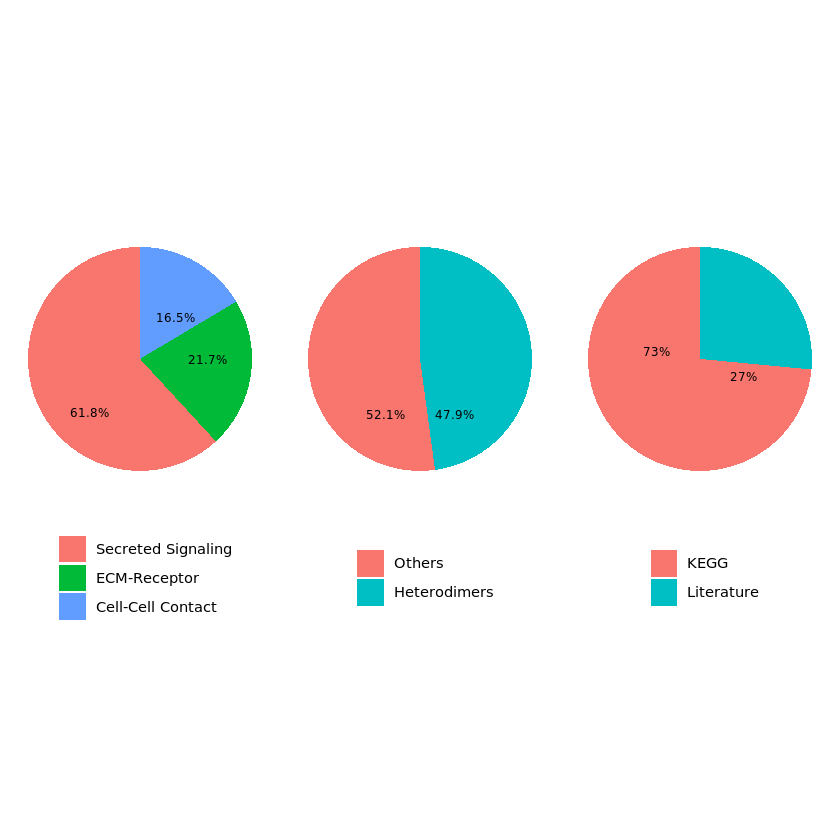

In [21]:
showDatabaseCategory(CellChatDB)

In [174]:
cellchat <- subsetData(cellchat) # subset the expression data 取了表达矩阵的一个子集

In [173]:
future::plan("multiprocess", workers = 4) # do parallel
#future::plan("sequential") #放弃并行
cellchat <- identifyOverExpressedGenes(cellchat) #设置data.use = cellchat@data, 使用完整的表达矩阵
cellchat <- identifyOverExpressedInteractions(cellchat)
# project gene expression data onto PPI network (optional)
cellchat <- projectData(cellchat, PPI.human)

In [186]:
cellchat <- computeCommunProb(cellchat)
#Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 10)

In [ ]:
#以数据框的形式提取细胞间相互作用
df.net <- subsetCommunication(cellchat, sources.use = c(1,2), targets.use = c(4,5)) 
#gives the inferred cell-cell communications sending from cell groups 1 and 2 to cell groups 4 and 5

In [191]:
#Calculate the aggregated cell-cell communication network
cellchat <- aggregateNet(cellchat)

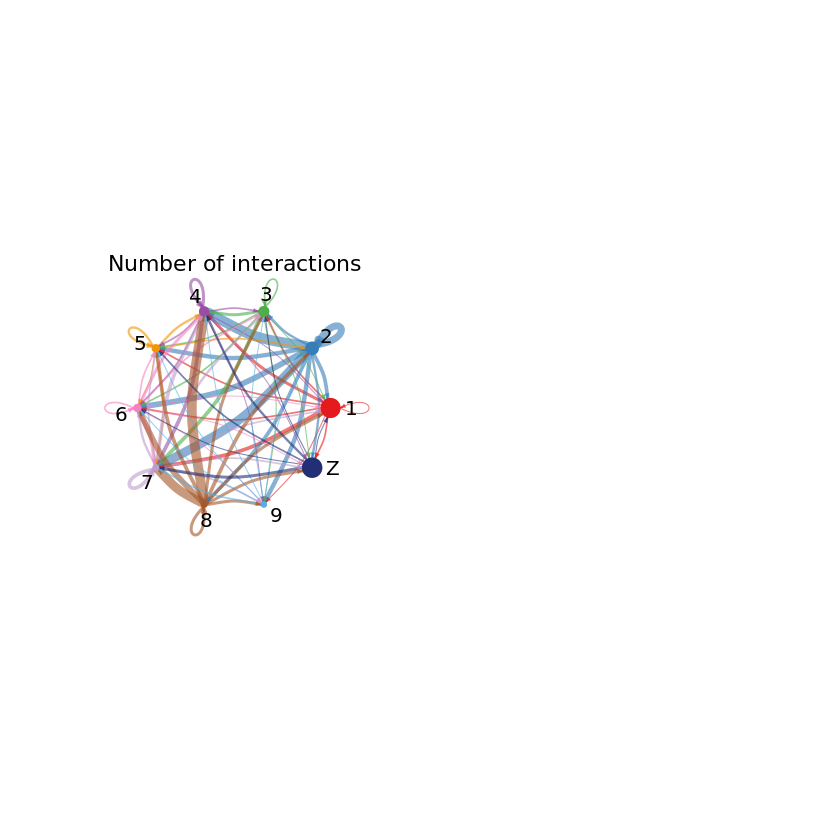

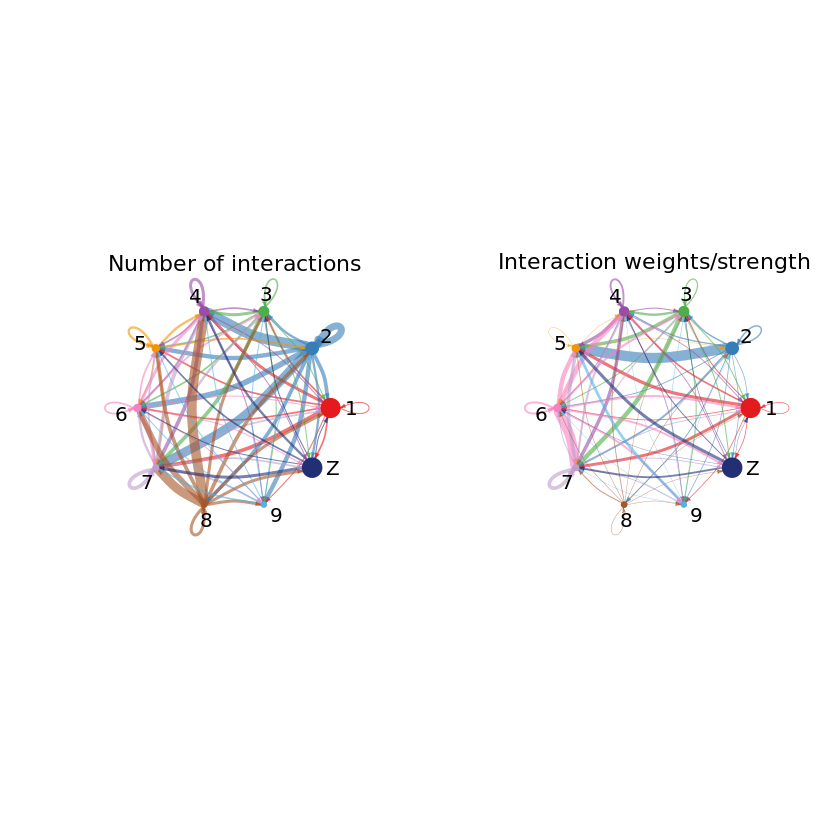

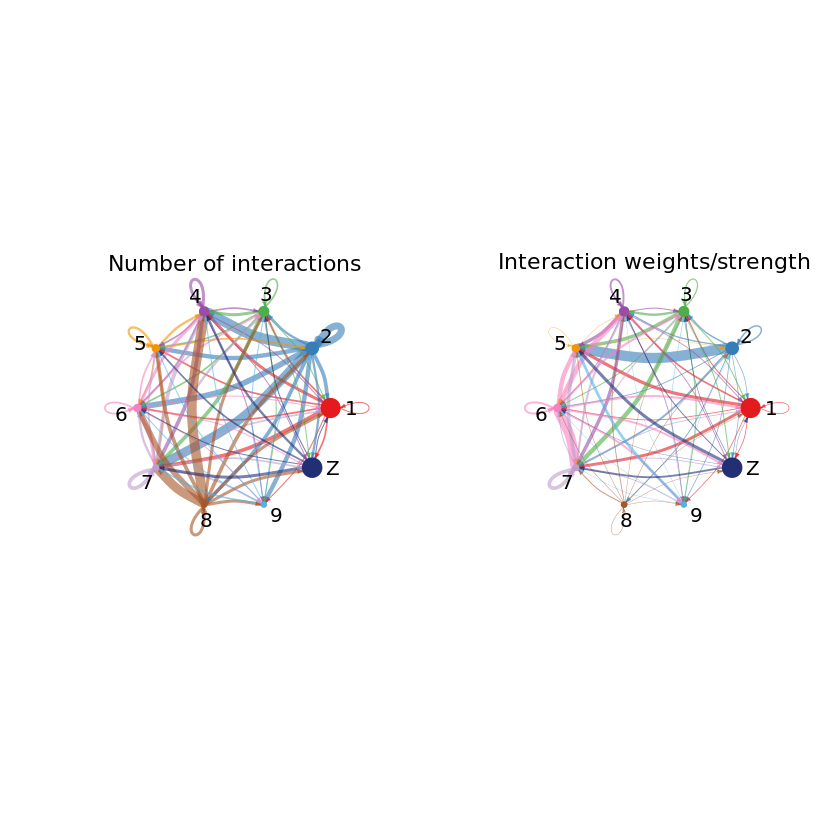

In [209]:
#plot number/strenth of interaction
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

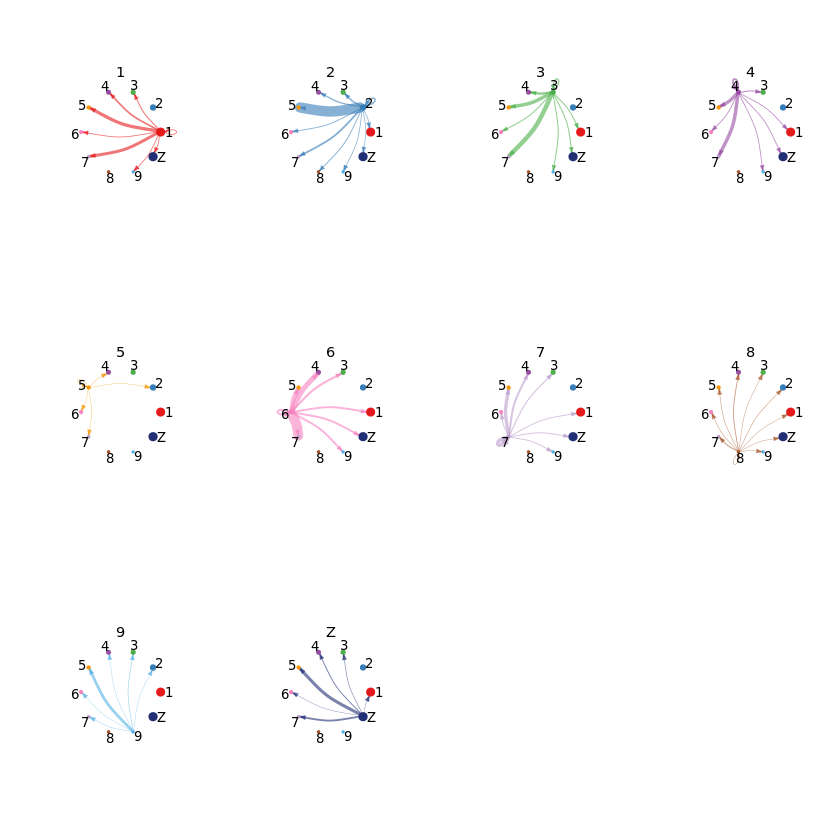

In [212]:
#单独画出每个群的与其他群的interaction
mat <- cellchat@net$weight #mat 权重矩阵
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) { 
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

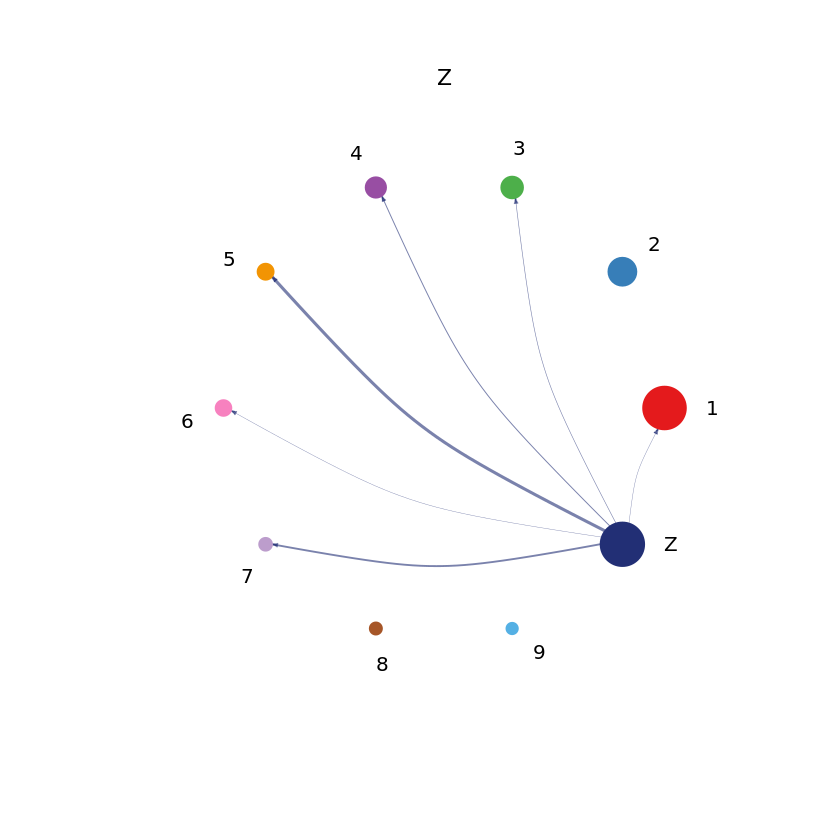

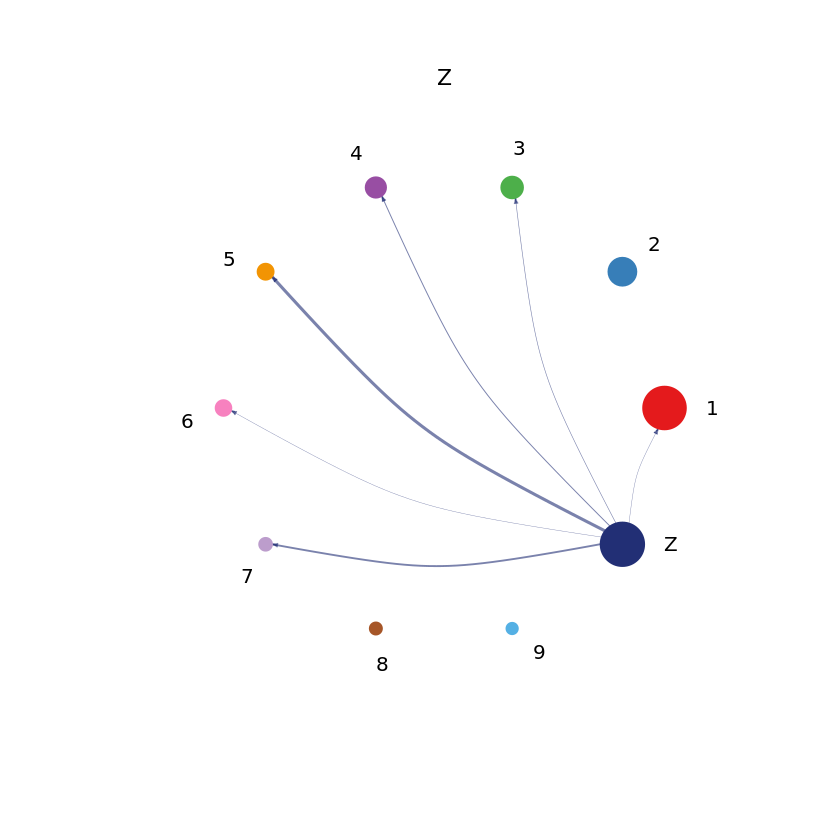

In [214]:
#画Z
i<- 10 #i为Z群在权重矩阵中的索引值
mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
mat2[i, ] <- mat[i, ]
netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])

In [269]:
names(table(cellchat@LR$LRsig$pathway_name))->pathway_name #查看通路名

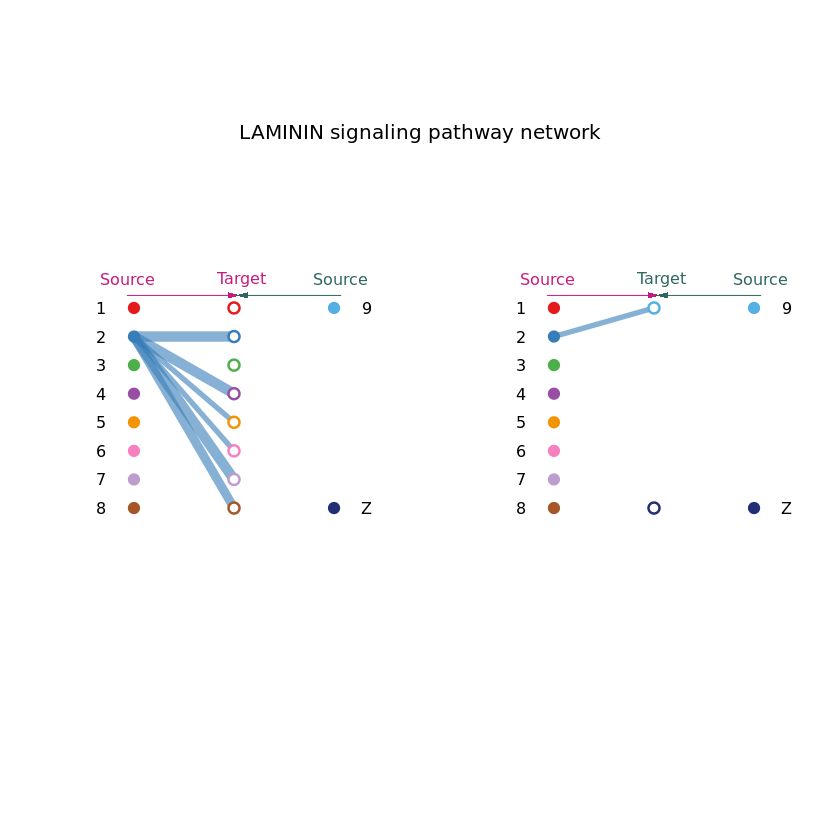

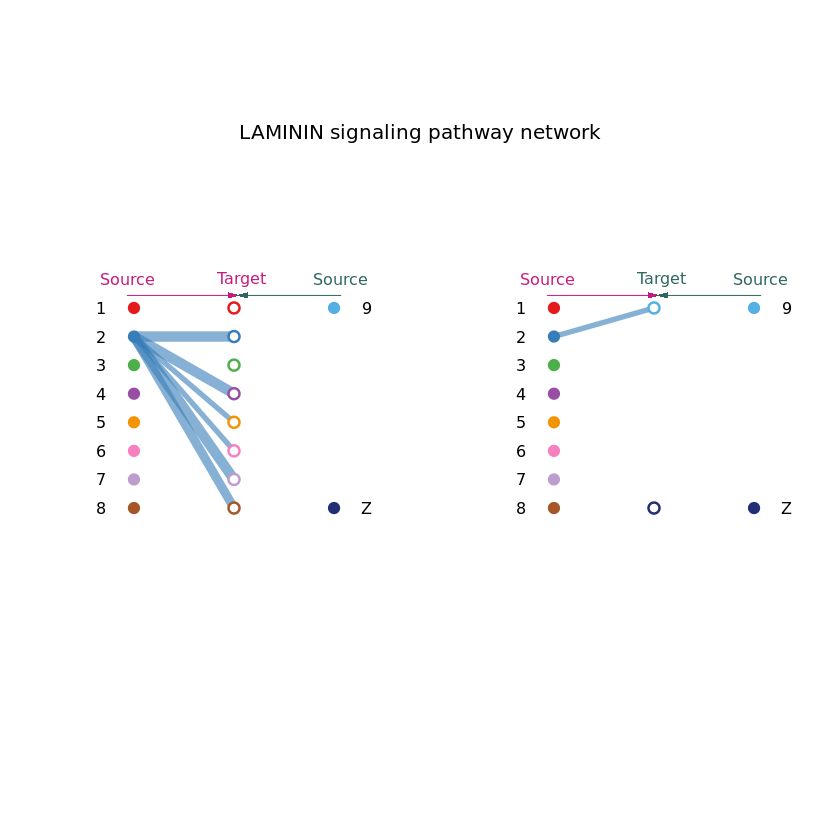

In [257]:
#plot Pathways
pathways.show <- c("LAMININ")
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(8) # a numeric vector. 表示要显示的群的索引, 索引到不包含该pathway的群会报错，直接用layout="circle"不用设置vertex
netVisual_aggregate(cellchat, signaling = pathways.show,vertex.receiver = vertex.receiver,layout = "hierarchy")
#layout = c("circle", "hierarchy", "chord"),

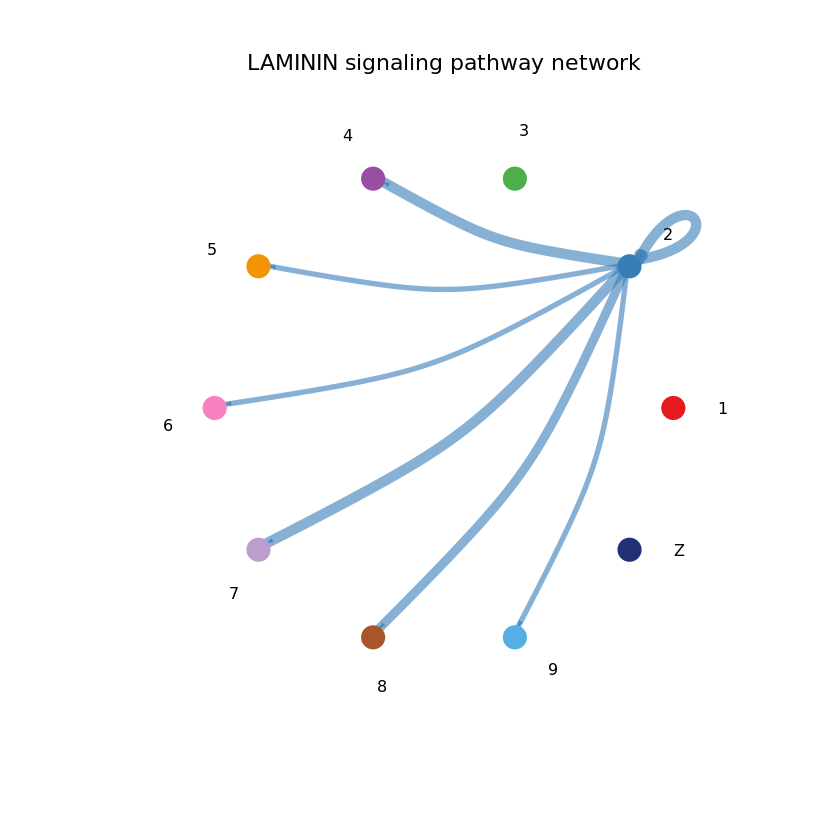

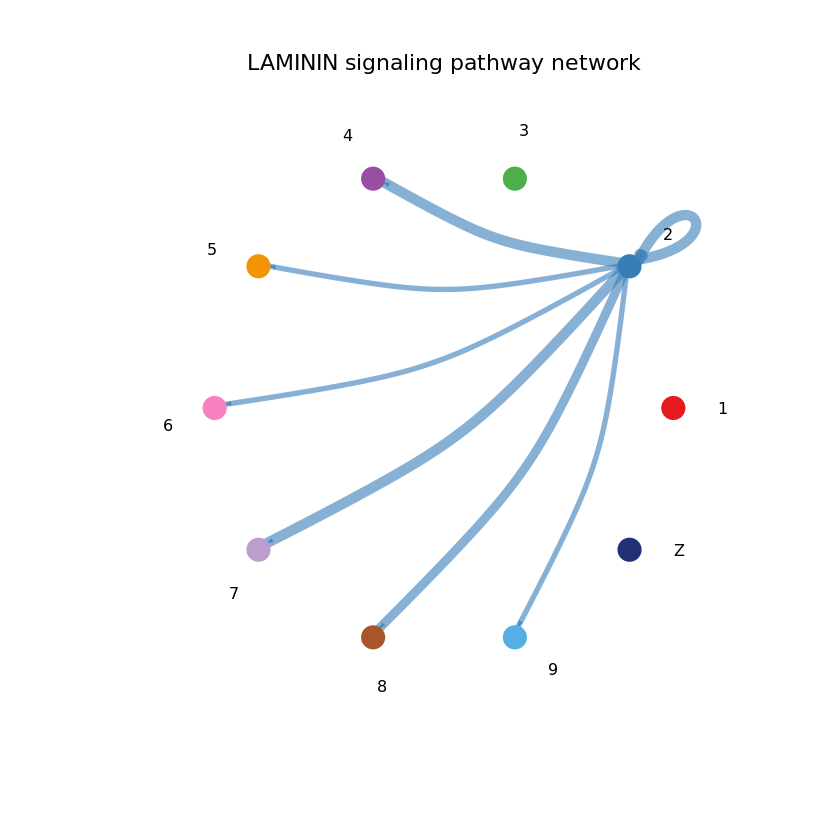

In [258]:
netVisual_aggregate(cellchat, signaling = pathways.show) #default circle

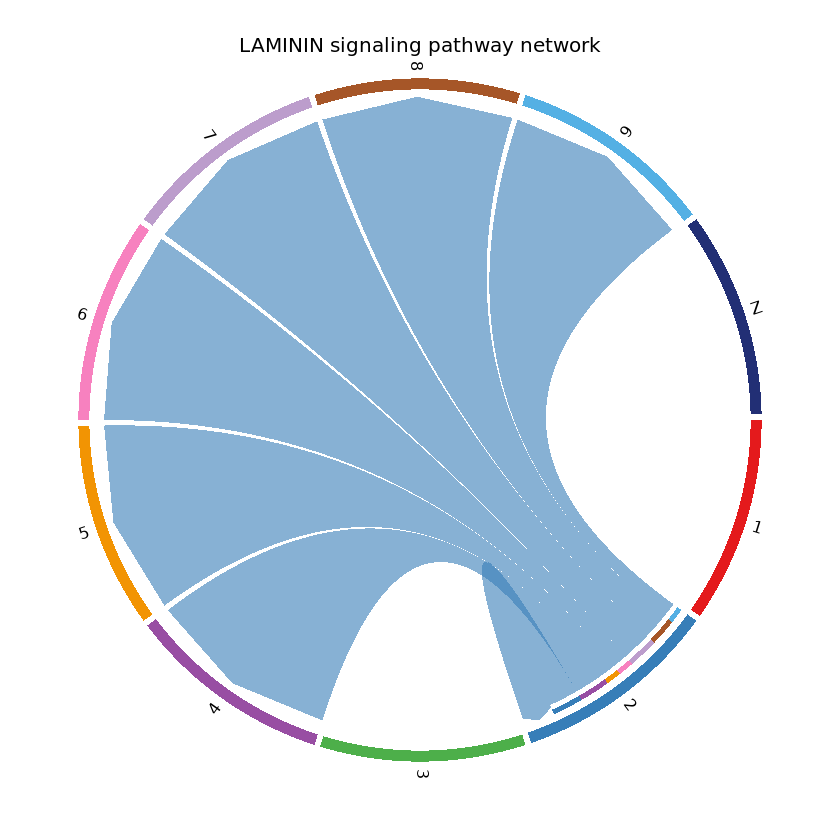

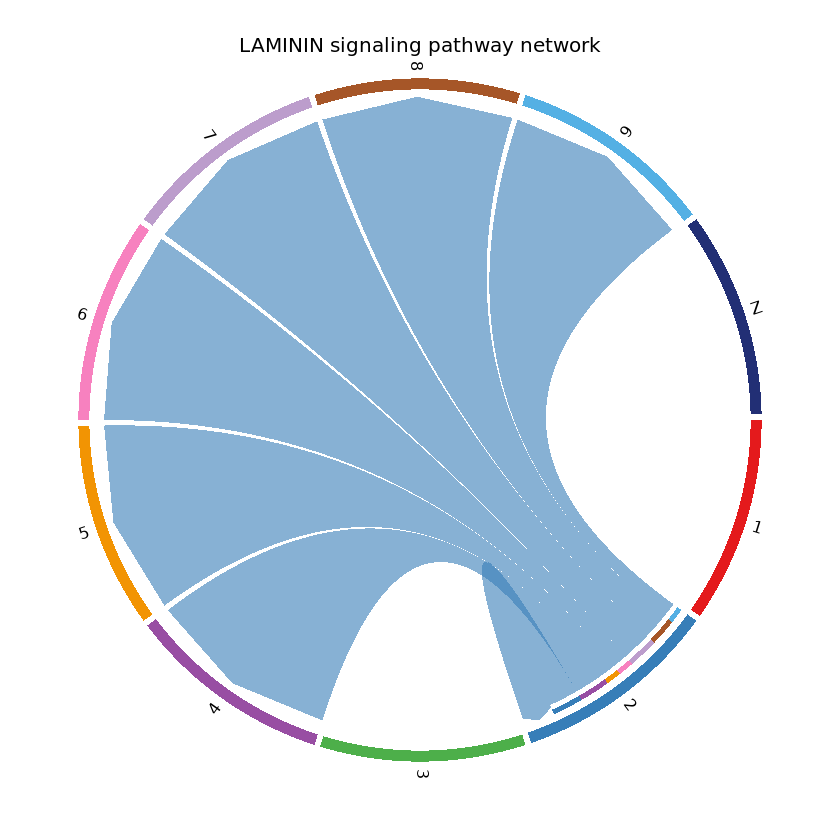

In [259]:
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")

Do heatmap based on a single object 




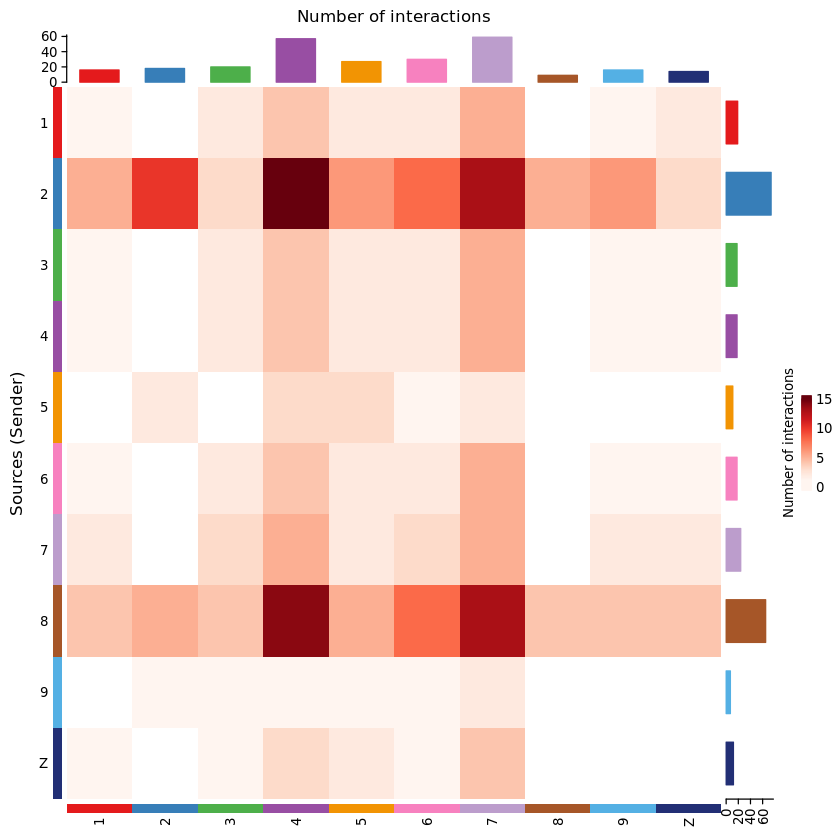

In [272]:
# Heatmap
par(mfrow=c(1,1))
netVisual_heatmap(cellchat,color.heatmap = "Reds")

Plot the aggregated cell-cell communication network at the signaling pathway level



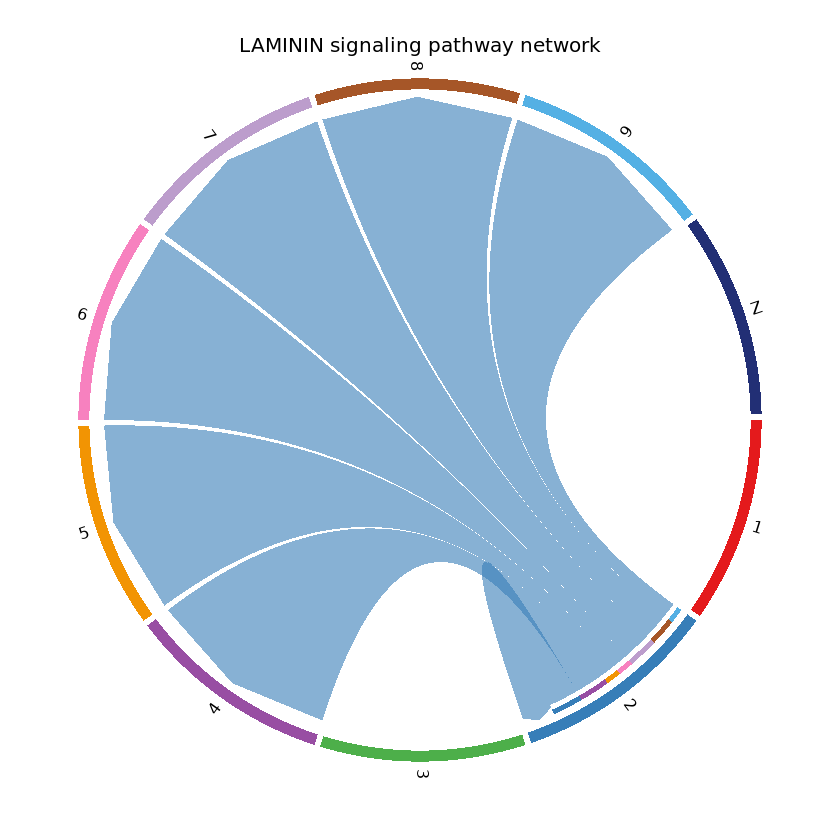

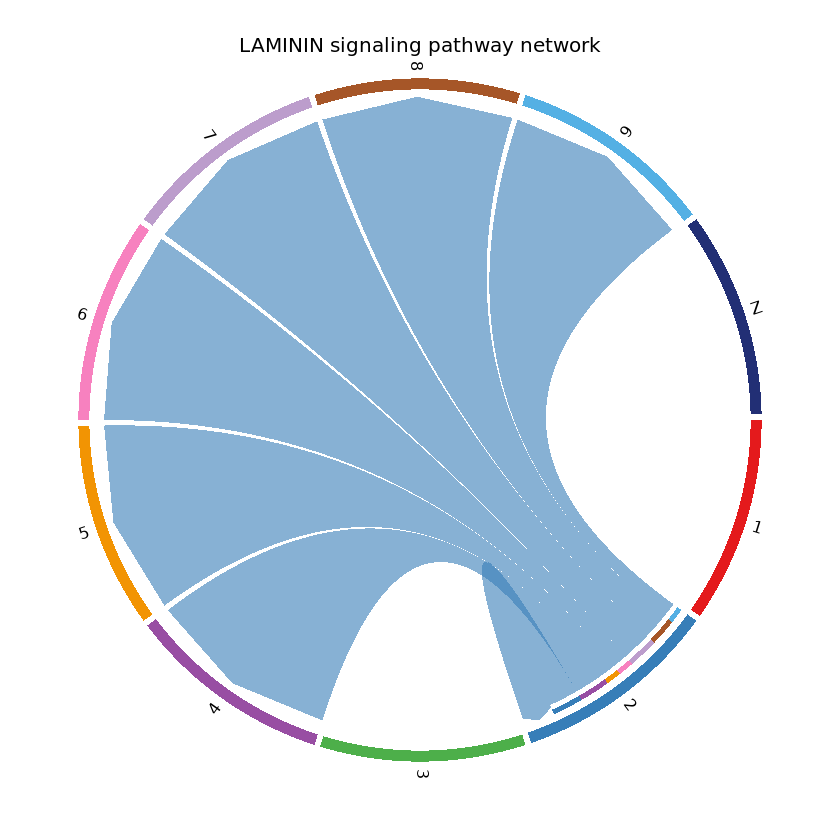

In [274]:
# Chord diagram
netVisual_chord_cell(cellchat, signaling = pathways.show)

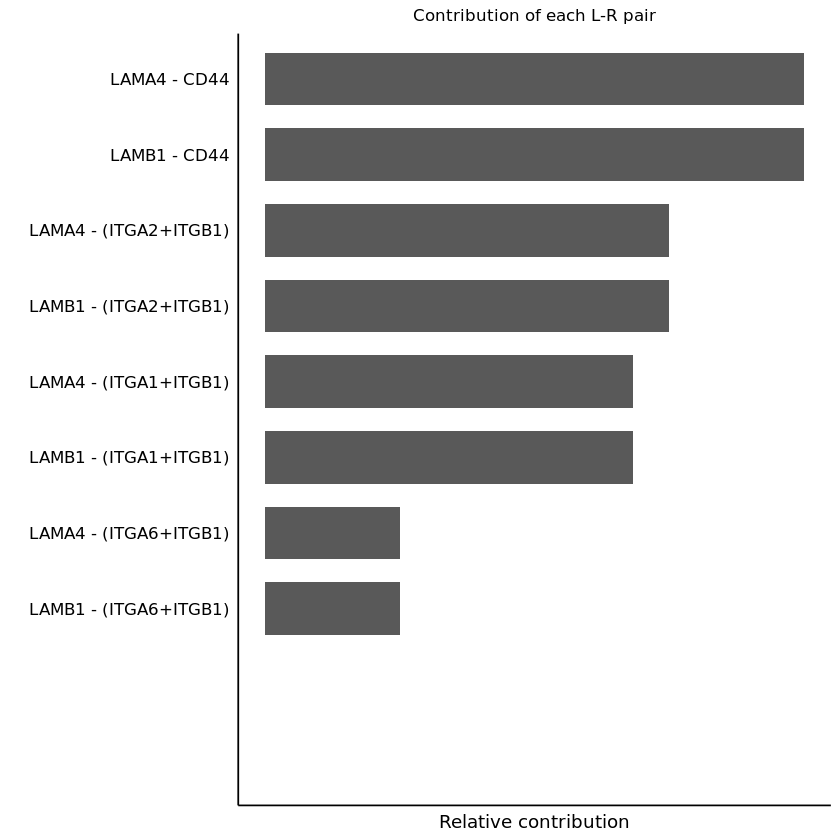

In [275]:
#Compute the contribution of each ligand-receptor pair to the overall signaling pathway and visualize cell-cell communication mediated by a single ligand-receptor pair
netAnalysis_contribution(cellchat, signaling = pathways.show)

Comparing communications on a single object 




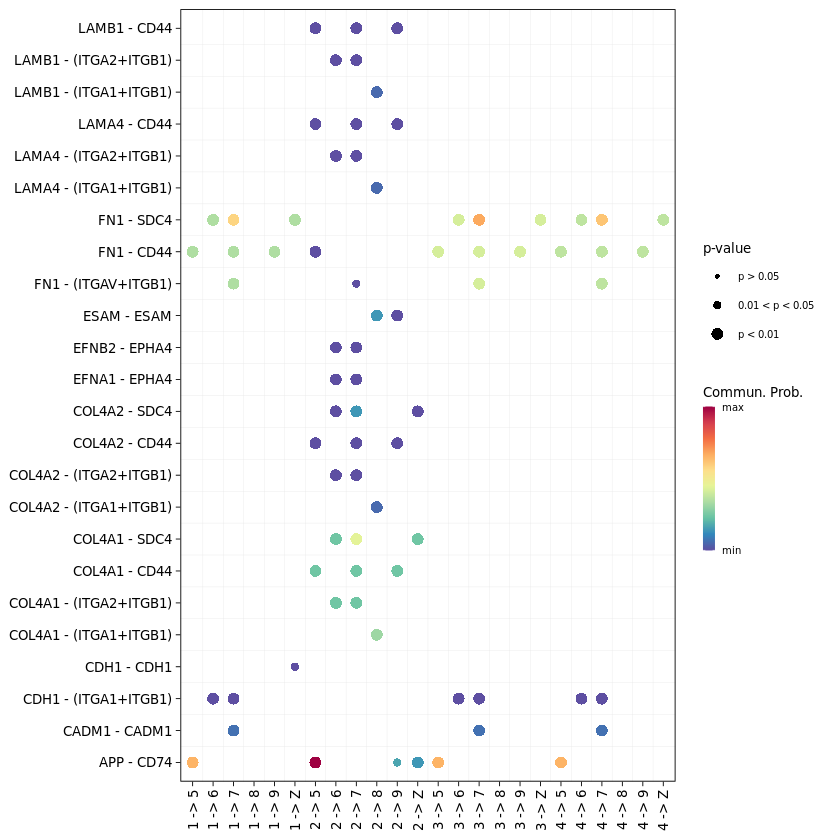

In [276]:
#Visualize cell-cell communication mediated by multiple ligand-receptors or signaling pathways
netVisual_bubble(cellchat, sources.use = c(1:4), targets.use = c(5:10), remove.isolate = FALSE)

Comparing communications on a single object 




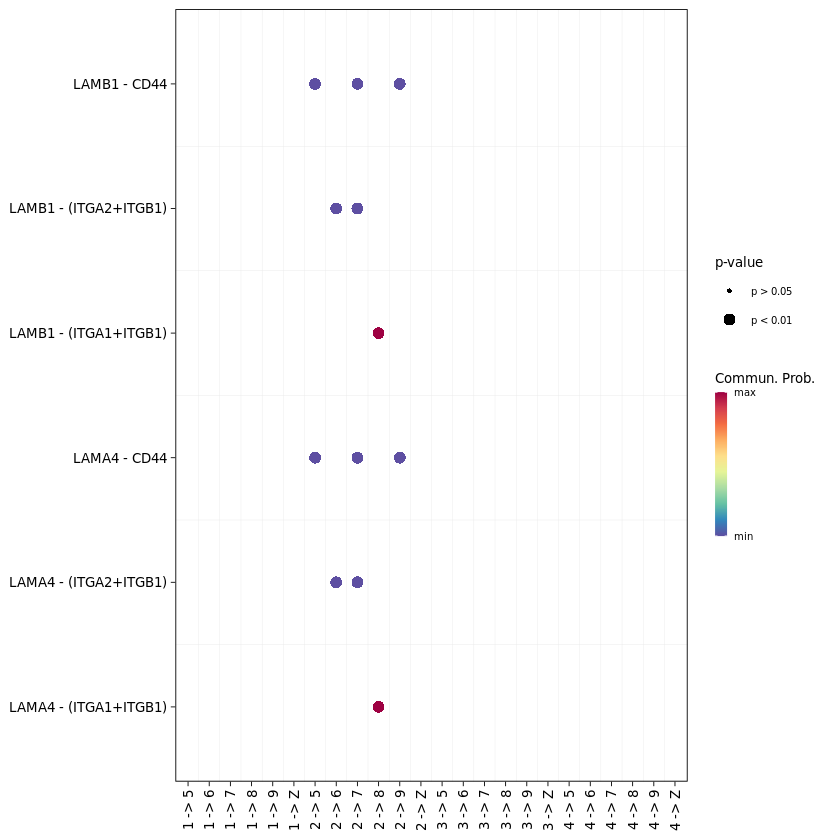

In [278]:
# show all the significant interactions (L-R pairs) associated with certain signaling pathways
netVisual_bubble(cellchat, sources.use = c(1:4), targets.use = c(5:10), signaling = pathways.show, remove.isolate = FALSE)

Comparing communications on a single object 




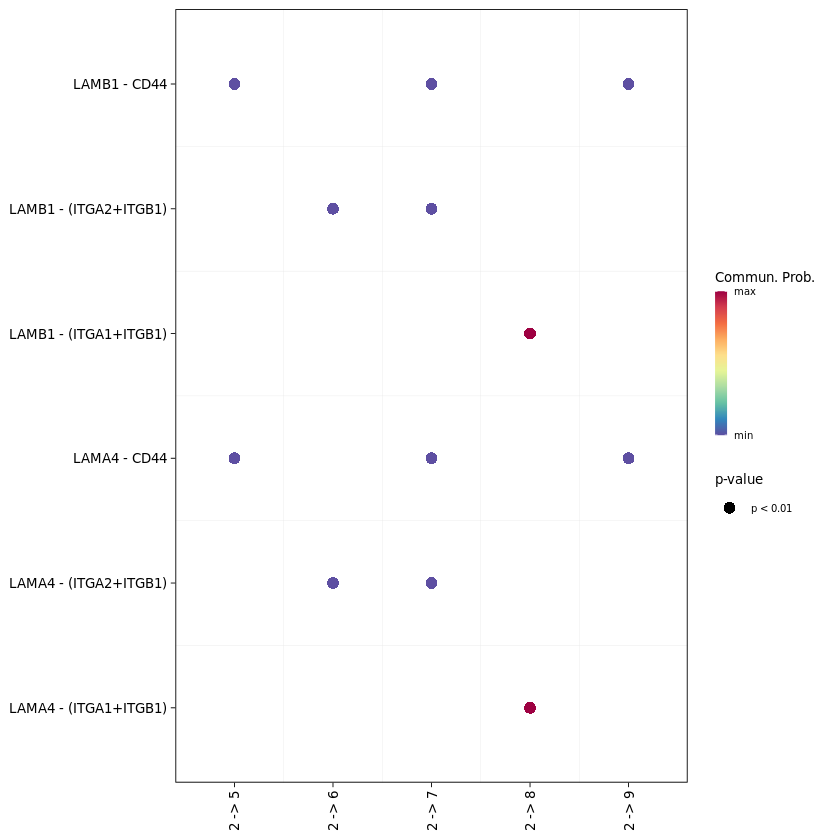

In [280]:
# show all the significant interactions (L-R pairs) based on user's input (defined by `pairLR.use`)
pairLR.use <- extractEnrichedLR(cellchat, signaling = pathways.show)
netVisual_bubble(cellchat, sources.use = c(2,4), targets.use = c(5:10), pairLR.use = pairLR.use, remove.isolate = TRUE)

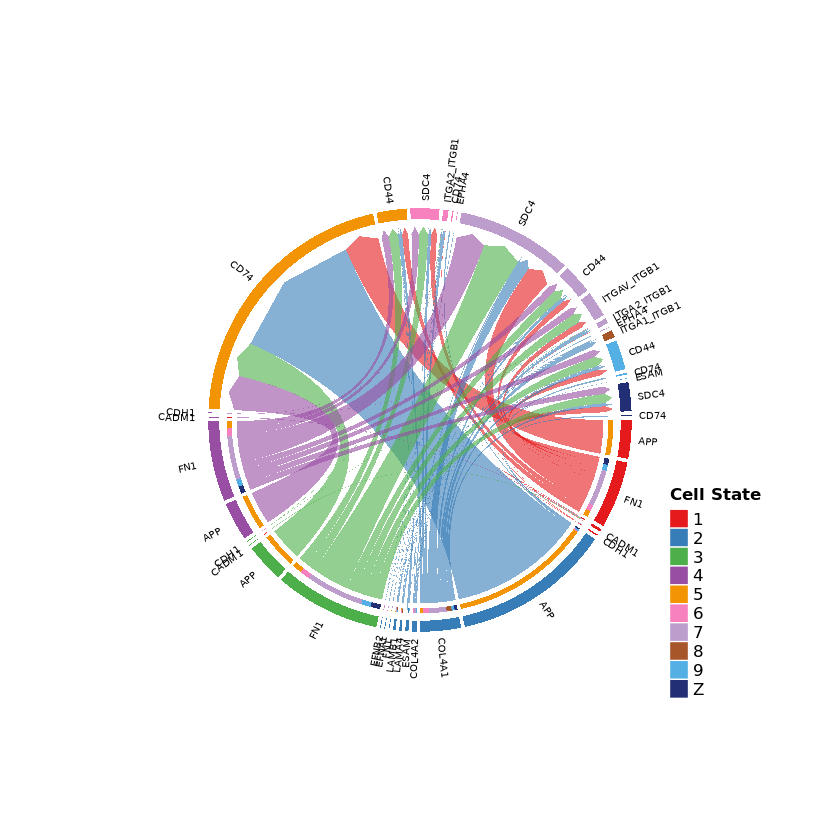

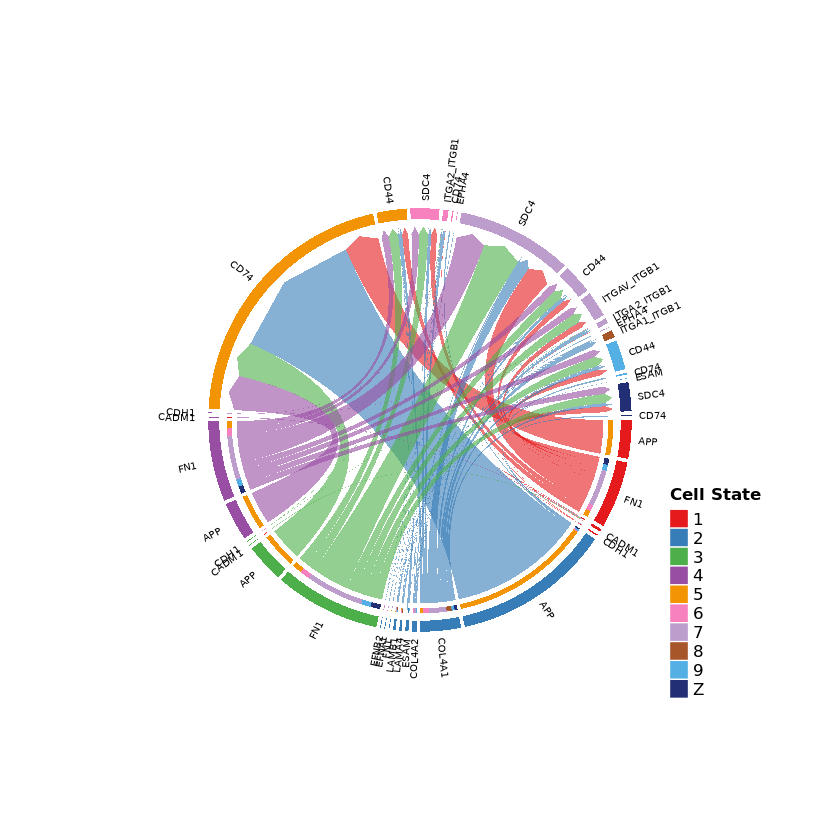

In [281]:
# show all the significant interactions (L-R pairs) from some cell groups (defined by 'sources.use') to other cell groups (defined by 'targets.use')
# show all the interactions sending from Inflam.FIB
netVisual_chord_gene(cellchat, sources.use = c(1:4), targets.use = c(5:10), lab.cex = 0.5,legend.pos.y = 30)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



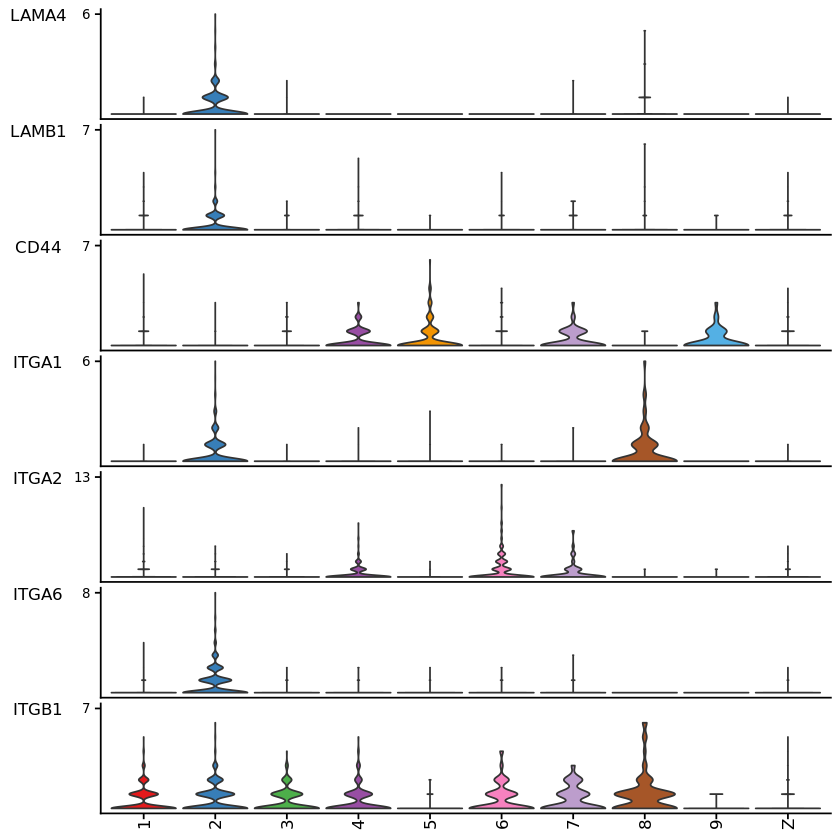

In [282]:
#Plot the signaling gene expression distribution using violin/dot plot
plotGeneExpression(cellchat, signaling = pathways.show)